In [2]:
from gmtra import fetch
from gmtra import utils
from gmtra import hazard

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import tqdm
%matplotlib inline

### Road network data preparation

In [4]:
data_path = "C:\\Users\\path to OSM's .osm.pbf file"
country = 'indonesia'

roads_gdf = fetch.roads(data_path, country)

In [38]:
roads_gdf['length'] = roads_gdf.geometry.apply(utils.line_length)

In [40]:
roads_gdf.geometry = roads_gdf.geometry.simplify(tolerance=0.5)

In [42]:
road_dict = utils.map_roads()

In [43]:
roads_gdf['road_type'] = roads_gdf.infra_type.apply(lambda x: road_dict[x])

In [6]:
#take into account only primary and secondary roads
roads_gdf = roads_gdf.loc[roads_gdf['road_type'].isin(['primary', 'secondary'])]

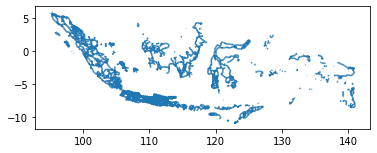

In [46]:
roads_gdf.plot()

In [44]:
roads_gdf.to_file('osmconvert/country_osm/idn_roads_mod1.shp')

### Functions to polygonize hazard rasters and to overlay hazard maps with road networks

In [3]:
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
from shapely.geometry import mapping
import numpy as np

def single_polygonized(flood_path,flood_scen,adm_boundary):
    """
    modified from:
    https://github.com/ElcoK/gmtra/blob/master/gmtra/hazard.py
    """
    
    geometry = adm_boundary['geometry'].iloc[0]
    geoms = [mapping(geometry)]
    
    # load hazard map with rasterio and clip it to the area we are interested in.
    with rasterio.open(flood_path) as src:
        out_image, out_transform = mask(src, geoms, crop=True)

        # change points in waterbodies and zeros to -1, so we can easily remove it from the dataset
        out_image = np.round(out_image,1)
        
        # change to centimeters and integers, substantially reduces the size.
        out_image = np.array(out_image,dtype='int32')

        # the actual polygonization of the raster map
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v)
            in enumerate(
            shapes(out_image[0,:,:], mask=None, transform=out_transform)))

        # and save to a new geopandas GeoDataFrame
        gdf = gpd.GeoDataFrame.from_features(list(results),crs='epsg:4326')
        gdf = gdf.loc[gdf.raster_val > 25] #gdf.loc[gdf.raster_val > 0] for flood
        gdf['geometry'] = gdf.buffer(0) #gdf.buffer(0.00025) for flood
        gdf['hazard'] = flood_scen
    
    return gdf

In [15]:
def road_exposure(road_gdf, hzd_region2, hzd_name):
    
    infra_gpd = road_gdf.copy()
    hzd_region = hzd_region2.copy()
    
    # now lets intersect the hazard with the ifnrastructure asset and 
    #get the hazard values and intersection lengths for each asset.
    hzd_reg_sindex = hzd_region.sindex
    tqdm.tqdm.pandas(desc=hzd_name+'_indonesia') 
    inb = infra_gpd.progress_apply(lambda x: hazard.intersect_hazard(x,hzd_reg_sindex,hzd_region),axis=1).copy()
    inb = inb.apply(pd.Series)
    inb.columns = ['geometry','val_{}'.format(hzd_name)]
    inb['length_{}'.format(hzd_name)] = inb.geometry.apply(utils.line_length)
    
    # and at the results to the dataframe with all the infrastructure assets.
    infra_gpd[['length_{}'.format(hzd_name),'val_{}'.format(hzd_name)]] = inb[['length_{}'.format(hzd_name),
                                                                               'val_{}'.format(hzd_name)]]
    
    return infra_gpd

### 100-yr riverine flood

In [4]:
flood_path = 'hazard_data/Hazard_IDN__100.grd'
adm_boundary = gpd.read_file('osmconvert/adm_boundary/IDN_adm0.shp')
flood_scen = 'flood_100yr'

flood_100_gdf = single_polygonized(flood_path,flood_scen,adm_boundary)

C:\Users\bjafino\anaconda3\envs\GMTRA\lib\site-packages\numpy\core\fromnumeric.py:56: RuntimeWarning: overflow encountered in multiply
  return getattr(obj, method)(*args, **kwds)


In [5]:
hzd_region = flood_100_gdf.copy()
hzd_region.reset_index(inplace=True,drop=True)

In [37]:
hzd_name = 'flood_100yr'

In [41]:
hzd_name = 'flood_100yr'
roads_exposed_gdf = road_exposure(roads_gdf, hzd_region, hzd_name)

flood_100yr_indonesia: 100%|████████████████████████████████████████████████████| 87235/87235 [02:32<00:00, 573.37it/s]


In [42]:
roads_exposed_gdf = roads_exposed_gdf.loc[roads_exposed_gdf['val_flood_100yr']>0]

In [44]:
roads_exposed_gdf.to_file('osmconvert/hazard_intersect/road_flood_100yr.shp')

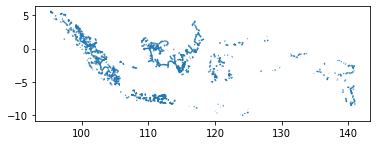

In [45]:
roads_exposed_gdf.plot()

### 1000-yr riverine flood

In [48]:
flood_path = 'hazard_data/Hazard_IDN__1000.grd'
adm_boundary = gpd.read_file('osmconvert/adm_boundary/IDN_adm0.shp')
flood_scen = 'flood_1000yr'

flood_1000_gdf = single_polygonized(flood_path,flood_scen,adm_boundary)

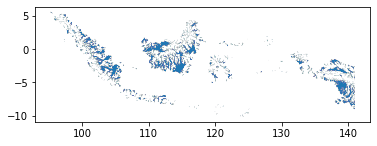

In [49]:
flood_1000_gdf.plot()

In [50]:
hzd_region = flood_1000_gdf.copy()
hzd_region.reset_index(inplace=True,drop=True)

In [51]:
hzd_name = 'flood_1000yr'
roads_exposed_gdf = road_exposure(roads_gdf, hzd_region, hzd_name)

flood_1000yr_indonesia: 100%|███████████████████████████████████████████████████| 87235/87235 [02:42<00:00, 538.39it/s]


In [52]:
roads_exposed_gdf = roads_exposed_gdf.loc[roads_exposed_gdf['val_flood_1000yr']>0]

In [54]:
roads_exposed_gdf.to_file('osmconvert/hazard_intersect/road_flood_1000yr.shp')

### 250-yr earthquakes

In [44]:
flood_path = 'hazard_data/Seismic hazard_PGA_RT250years.grd'
adm_boundary = gpd.read_file('osmconvert/adm_boundary/IDN_adm0.shp')
flood_scen = 'PGA_250yr'

pga_250_gdf = single_polygonized(flood_path,flood_scen,adm_boundary)

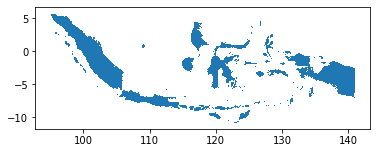

In [45]:
pga_250_gdf.plot()

In [46]:
hzd_region = pga_250_gdf.copy()
hzd_region.reset_index(inplace=True,drop=True)

In [47]:
hzd_name = 'pga_250yr'
roads_exposed_gdf = road_exposure(roads_gdf, hzd_region, hzd_name)

pga_250yr_indonesia: 100%|██████████████████████████████████████████████████████| 87235/87235 [04:52<00:00, 277.93it/s]


In [48]:
roads_exposed_gdf = roads_exposed_gdf.loc[roads_exposed_gdf['val_pga_250yr']>0]

In [50]:
roads_exposed_gdf.to_file('osmconvert/hazard_intersect/road_pga_250yr.shp')

### 2475-yr earthquakes

In [51]:
flood_path = 'hazard_data/Seismic hazard_PGA_RT2475years.grd'
adm_boundary = gpd.read_file('osmconvert/adm_boundary/IDN_adm0.shp')
flood_scen = 'PGA_2475yr'

pga_2475_gdf = single_polygonized(flood_path,flood_scen,adm_boundary)

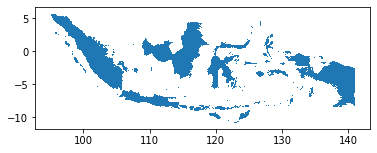

In [52]:
pga_2475_gdf.plot()

In [53]:
hzd_region = pga_2475_gdf.copy()
hzd_region.reset_index(inplace=True,drop=True)

In [54]:
hzd_name = 'pga_2475yr'
roads_exposed_gdf = road_exposure(roads_gdf, hzd_region, hzd_name)

pga_2475yr_indonesia: 100%|█████████████████████████████████████████████████████| 87235/87235 [04:57<00:00, 293.33it/s]


In [55]:
roads_exposed_gdf = roads_exposed_gdf.loc[roads_exposed_gdf['val_pga_2475yr']>0]

In [57]:
roads_exposed_gdf.to_file('osmconvert/hazard_intersect/road_pga_2475yr.shp')